# DS598 A1 - Introduction to Reinforcement Learning - Homework 2

### Carmen Pelayo Fernández - February 2024

## Problem 1 - Environment



In [1]:
import numpy as np
import gym
from gym import spaces
import torch

# If GPU is available, use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GridworldEnv(gym.Env):

    def __init__(self):
        self.height = 4
        self.width = 4
        self.action_space = spaces.Discrete(4)  # 0: up, 1: right, 2: down, 3: left
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.height, self.width), dtype=np.float32)
        self.state = np.array([3,0]) # Start state (S0) at the bottom-left corner
        self.treasure_state = np.array([0,0])  # Reward (10) at the top-left corner
        self.wall_state = [(1, 0), (1, 1), (1, 2)] # Wall beneath the treasure
        self.gamma = 0.9
        self.n_steps = 0

    def reset(self):
        self.state = np.array([3,0])  # Reset to start state (S0)
        return self.state

    def step(self, action):
        assert self.action_space.contains(action)
        self.n_steps += 1 # Add step to counter to discount the reward accordingly
        y, x = self.state

        # Take action
        if action == 0:  # up
          if y == 1 and x < 3: # check if the state is just under the wall
            next_state = self.state # Do not move
          else:
            next_state = np.array([max(y - 1, 0), x])

        elif action == 1:  # right
            next_state = np.array([y, min(x + 1, self.width - 1)])

        elif action == 2:  # down
          if y == 0 and x < 3: # check if the state is just over the wall
            next_state = self.state # Do not move
          else:
            next_state = np.array([min(y + 1, self.height - 1), x])

        elif action == 3:  # left
            next_state = np.array([y, max(x - 1, 0)])

        # Check for treasure
        if np.array_equal(next_state, self.treasure_state):
            reward = (self.gamma ** self.n_steps) * 10
            done = True
        else:
            reward = 0
            done = False

        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        grid = np.full((self.height, self.width), '.')  # Initialize the grid with '.'
        grid[self.treasure_state[0], self.treasure_state[1]]= 'T'  # Mark the treasure
        grid[self.state[0], self.state[1]] = 'S'  # Mark the agent's current state
        print('\n'.join(' '.join(str(cell) for cell in row) for row in grid))

# Usage
env = GridworldEnv()
obs = env.reset()
done = False
total_reward = 0

while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_reward += reward
    env.render()
    print(f"Observation: {obs}, Reward: {reward}, Total Reward: {total_reward}")

# Clean up
#env.close()

T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
S . . .
. . . .
Observation: [2 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
S . . .
. . . .
Observation: [2 0], Reward: 0, Total Reward: 0
T . . .
. . . .
. S . .
. . . .
Observation: [2 1], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
. S . .
Observation: [3 1], Reward: 0, Total Reward: 0
T . . .
. . . .
. . . .
S . . .
Observation: [3 0], Reward: 0, Total Reward: 0
T . . .
. . . .
S . . .
. . . .
Observation: [2 0], 

## Problem 2 - DQN

In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, n_actions)  # Two-layer MLP

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return self.layer2(x)  # Q-values for each action

# Hyperparameters (adjust as needed)
EPS_START = 0.95
EPS_END = 0.25
EPS_DECAY = 200 # Controls the rate of exponential decay of ϵ (higher means a slower decay)
BATCH_SIZE = 128

# Function for selecting actions with ϵ-greedy exploration
def select_action(state, policy_net, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    sample = random.random()

    # Selecting best action
    if sample > eps_threshold:
        with torch.no_grad():
            # Ensure state has batch dimension and correct shape
            state = state.unsqueeze(0)
            q_values = policy_net(state)
            action = q_values.argmax(dim=1)
            return action.item()

    # ϵ-greedy Exploration
    else:
        return random.randrange(n_actions)

# Named tuple for storing transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Replay memory to store and sample transitions
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Initialize the Gridworld environment
env = GridworldEnv()

# Get the number of actions and observations
n_actions = env.action_space.n
#n_observations = env.observation_space.shape[0]
state = env.reset()
n_observations = len(state)

# Initialize Q-networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initialize optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
memory = ReplayMemory(10000)

### Part 1

In [3]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = state_batch.view(-1, 2)
    action_batch = action_batch.view(-1, 1)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(dim=1).values
    # Compute the expected Q values

    expected_state_action_values = (next_state_values * env.gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss

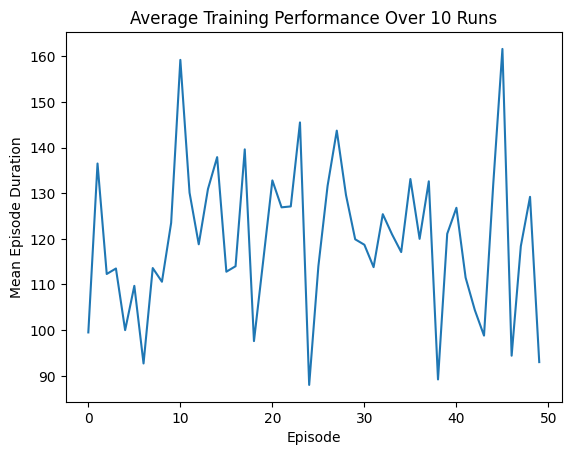

In [4]:
from statistics import mean

# Training loop
num_episodes = 50
num_runs = 10
all_runs_durations = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    episode_durations = []  
    for i_episode in range(num_episodes):
        state = torch.tensor(env.reset(), device=device, dtype=torch.float)
        for t in count():
            action = select_action(state, policy_net, t)
            observation, reward, done, _ = env.step(action)
            reward = torch.tensor([reward], device=device)
            if not done:
                next_state = torch.tensor(observation, device=device, dtype=torch.float)
            else:
                next_state = None
    
            # Store the transition in memory
            memory.push(state, torch.tensor([action], device=device), next_state, reward)
    
            # Move to the next state
            state = next_state
            # Perform one step of the optimization (on the policy network)
            optimize_model()
    
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
            target_net.load_state_dict(target_net_state_dict)
    
            if done or t > 200:
                episode_durations.append(t + 1)
                break
    all_runs_durations[run] = episode_durations
average_durations = np.mean(all_runs_durations, axis=0)

plt.plot(average_durations, label='Average Performance')
plt.xlabel('Episode')
plt.ylabel('Mean Episode Duration')
plt.title('Average Training Performance Over 10 Runs')
plt.show()

In [5]:
'''
state = torch.tensor(env.reset(), device=device, dtype=torch.float)
timer = 0
while True:
    # Render the environment
    env.render()
    print()

    # Get the agent's action
    action = select_action(state, policy_net, timer)
    # Take a step in the environment
    next_state, reward, done, _ = env.step(action)

    # Check if the game is over
    if done:
        print(f'time: {timer}')
        break

    # Update the state
    state = torch.tensor(next_state, device=device, dtype=torch.float)
    timer += 1
'''

"\nstate = torch.tensor(env.reset(), device=device, dtype=torch.float)\ntimer = 0\nwhile True:\n    # Render the environment\n    env.render()\n    print()\n\n    # Get the agent's action\n    action = select_action(state, policy_net, timer)\n    # Take a step in the environment\n    next_state, reward, done, _ = env.step(action)\n\n    # Check if the game is over\n    if done:\n        print(f'time: {timer}')\n        break\n\n    # Update the state\n    state = torch.tensor(next_state, device=device, dtype=torch.float)\n    timer += 1\n"

### Part 2

In [6]:
def optimize_model_DoubleDQN():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = state_batch.view(-1, 2)
    action_batch = action_batch.view(-1, 1)
    state_action_values = policy_net(state_batch)
    next_state_action_values = policy_net(non_final_next_states)
    next_state_target_values = target_net(non_final_next_states)
    q_values = state_action_values.gather(1, action_batch)
    maxvals = torch.max(next_state_action_values, 1)[1].unsqueeze(1)
    next_q_values = next_state_target_values.gather(1, maxvals)
    non_final_mask = non_final_mask.unsqueeze(1)
    next_state_values = torch.zeros((BATCH_SIZE, 1), device=device)

    with torch.no_grad():
       next_state_values[non_final_mask] = next_q_values.squeeze(1)

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * env.gamma) + reward_batch.unsqueeze(1)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    #loss = criterion(state_action_values, expected_state_action_values)
    loss = criterion(q_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()

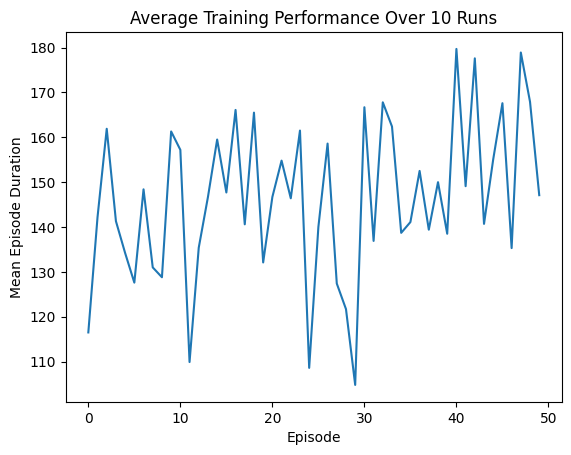

In [7]:
# Training loop
num_episodes = 50
num_runs = 10
all_runs_durations = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    episode_durations = []  
    for i_episode in range(num_episodes):
        state = torch.tensor(env.reset(), device=device, dtype=torch.float)
        for t in count():
            action = select_action(state, policy_net, t)
            observation, reward, done, _ = env.step(action)
            reward = torch.tensor([reward], device=device)
            if not done:
                next_state = torch.tensor(observation, device=device, dtype=torch.float)
            else:
                next_state = None
    
            # Store the transition in memory
            memory.push(state, torch.tensor([action], device=device), next_state, reward)
    
            # Move to the next state
            state = next_state
            # Perform one step of the optimization (on the policy network)
            optimize_model_DoubleDQN()
    
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
            target_net.load_state_dict(target_net_state_dict)
    
            if done or t > 200:
                episode_durations.append(t + 1)
                break
    all_runs_durations[run] = episode_durations
average_durations = np.mean(all_runs_durations, axis=0)

plt.plot(average_durations, label='Average Performance')
plt.xlabel('Episode')
plt.ylabel('Mean Episode Duration')
plt.title('Average Training Performance Over 10 Runs')
plt.show()

# Problem 3 - REINFORCE

In [12]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim

# Define the environment
env = GridworldEnv()  # Redefining the env.

# State and action space dimensions
n_observations = env.observation_space.shape[0]
#n_observations = len(state)
n_actions = env.action_space.n
'''
# Define the policy network as a two-layer MLP with a softmax output layer representing action probabilities.
class PolicyNet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)  
        self.fc2 = nn.Linear(128, n_actions)  
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x'''

class PolicyNet(torch.nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

# Initialize policy network and optimizer
policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)  

### Part 1

In [13]:
# Initialize the environment
env = GridworldEnv()

# Hyperparameters
GAMMA = 0.95
EPISODES = 200
BATCH_SIZE = 25  # Adjust as needed
LEARNING_RATE = 0.01  # Adjust as needed
RUNS = 10  

# Define the environment
n_observations = np.prod(env.observation_space.shape)  
n_actions = env.action_space.n

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize policy network and optimizer
policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Function to compute the learning curve over multiple runs
def compute_learning_curve(env, policy_net, optimizer, episodes, gamma, runs):
    run_durations = []

    for run in range(runs):
        episode_durations = []
        for episode in range(episodes):
            # Reset environment and episode-specific variables
            state = env.reset()
            state = state.flatten()  # Flatten the grid to a 1D array
            episode_reward = 0
            done = False
            states, actions, rewards = [], [], []

            while not done:
                # Convert state to tensor and get action probabilities
                state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
                action_probs = policy_net(state_tensor)

                # Sample action from the probabilities
                action = torch.multinomial(action_probs, 1).item()

                # Take action
                next_state, reward, done, _ = env.step(action)
                next_state = next_state.flatten()

                # Store the transition
                states.append(state)
                actions.append(action)
                rewards.append(reward)

                # Update current state
                state = next_state
                episode_reward += reward

            # Compute the discounted rewards (returns) going backwards from the last transition
            G = 0
            returns = []
            for reward in reversed(rewards):
                G = reward + GAMMA * G
                returns.insert(0, G)

            # Normalize returns
            returns = torch.tensor(returns, device=device, dtype=torch.float32)
            returns = (returns - returns.mean()) / (returns.std() + 1e-5)

            # Calculate policy loss and perform a policy update
            states_tensor = torch.tensor(states, device=device, dtype=torch.float32)
            actions_tensor = torch.tensor(actions, device=device, dtype=torch.long)
            log_probs = torch.log(policy_net(states_tensor))
            action_log_probs = log_probs[range(len(actions_tensor)), actions_tensor]
            loss = -(returns * action_log_probs).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the total number of steps it took to finish the episode
            episode_durations.append(len(states))

        run_durations.append(episode_durations)

    # Return the averaged learning curve
    return np.mean(run_durations, axis=0)

# Compute the learning curve
learning_curve = compute_learning_curve(env, policy_net, optimizer, EPISODES, GAMMA, RUNS)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(learning_curve)
plt.xlabel('Episode')
plt.ylabel('Average Episode Duration')
plt.title('REINFORCE Learning Curve Averaged Over 10 Runs')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

### Part 2

In [ ]:
import torch.optim as optim

def compute_advantage(returns, value_estimates):
    # Compute the advantage function A(s,a) = Q(s,a) - V(s)
    advantages = returns - value_estimates
    return advantages

def update_policy(policy_net, optimizer, advantages, log_probs):
    # Weight the log probabilities by the advantage and sum over all time steps
    policy_gradient = -(advantages * log_probs).sum()
    
    # Perform backpropagation and optimization step
    optimizer.zero_grad()
    policy_gradient.backward(retain_graph=True)
    optimizer.step()

def compute_returns(rewards, gamma=0.9):
    returns = []
    G = 0  # Cumulative return
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)
    return returns

# Function to estimate V*(s) for each state s
import torch
import torch.nn as nn
import torch.nn.functional as F

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        # Define the architecture of the network
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)  # Output a single value

    def forward(self, state):
        # Forward pass through the network
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Since the state is a 2D position, the input dimension is 2
value_net = ValueNetwork().to(device)

# Assuming policy_net is defined somewhere above
optimizer_policy = optim.Adam(policy_net.parameters(), lr=1e-2)
optimizer_value = optim.Adam(value_net.parameters(), lr=1e-2)
mse_loss = torch.nn.MSELoss()

In [ ]:
episode_durations = []  # List to store the number of steps per episode

for episode in range(50):
    log_probs = []
    states = []
    rewards = []
    state = env.reset()
    done = False
    steps = 0  # Step counter for this episode

    while not done:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_probs = policy_net(state_tensor)
        action_probs_softmax = torch.nn.functional.softmax(action_probs, dim=-1)
        m = torch.distributions.Categorical(action_probs_softmax)
        action = m.sample()
        log_prob = m.log_prob(action)
        
        log_probs.append(log_prob)
        next_state, reward, done, _ = env.step(action.item())
        states.append(state)
        rewards.append(reward)
        state = next_state
        steps += 1  # Increment the step counter

    # After episode ends, store the duration (i.e., steps in this episode)
    episode_durations.append(steps)
    
    returns = compute_returns(rewards, gamma)
    returns_tensor = torch.tensor(returns, dtype=torch.float32).to(device)
    states_np = np.array(states, dtype=np.float32)
    states_tensor = torch.tensor(states_np).to(device)
    value_estimates = value_net(states_tensor).squeeze()
    advantages = compute_advantage(returns_tensor, value_estimates)

    update_policy(policy_net, optimizer_policy, advantages, torch.stack(log_probs))
    
    optimizer_value.zero_grad()
    value_loss = mse_loss(value_estimates, returns_tensor)
    value_loss.backward()
    optimizer_value.step()

# Now plot the learning curve as episode duration per episode
plt.plot(episode_durations)
plt.title('Learning Curve - Episode Duration')
plt.xlabel('Episode')
plt.ylabel('Episode Duration (Steps)')
plt.show()

### Part 3

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNet(torch.nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

n_observations = np.prod(env.observation_space.shape)
n_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

def compute_returns(rewards, gamma=0.99):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns)

def compute_gradient_single_trajectory(policy_net, states, actions, rewards, use_baseline):
    policy_net.zero_grad()
    returns = compute_returns(rewards)
    if use_baseline:
        baseline = 0.5
    else:
        baseline = 0
    
    # Accumulate gradients across all time steps
    for state, action, R in zip(states, actions, returns):
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = policy_net(state_t)
        m = Categorical(action_probs)
        log_prob = m.log_prob(action)
        loss = -log_prob * (R - baseline)  # Use baseline to reduce variance
        loss.backward()  # This accumulates gradients for all parameters
    
    # Extract gradients for each parameter and stack them into a single tensor for each parameter
    gradients = [param.grad.data.clone() for param in policy_net.parameters()]
    return gradients

def collect_trajectory(env, policy_net):
    state = env.reset()
    states, actions, rewards = [], [], []
    done = False
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = policy_net(state_t)
        m = Categorical(action_probs)
        action = m.sample()
        state, reward, done, _ = env.step(action.item())
        states.append(state)
        actions.append(action)
        rewards.append(reward)
    return states, actions, torch.tensor(rewards)

def compute_empirical_variance(trajectories, policy_net, use_baseline):
    all_grads = []
    for traj in trajectories:
        states, actions, rewards = traj
        policy_net.zero_grad()  # Reset gradients
        compute_gradient_single_trajectory(policy_net, states, actions, rewards, use_baseline)
        grads = torch.cat([param.grad.view(-1) for param in policy_net.parameters() if param.grad is not None])
        all_grads.append(grads)
    # Compute the mean gradient
    mean_gradient = torch.mean(torch.stack(all_grads), axis=0)
    # Compute the empirical variance
    variance = torch.mean(torch.stack([(traj_grad - mean_gradient).pow(2) for traj_grad in all_grads]))
    return variance.item()

num_trajectories = 10
trajectories = []
for _ in range(num_trajectories):
    states, actions, rewards = collect_trajectory(env, policy_net)
    trajectories.append((states, actions, rewards))

# Compute variances
variance_with_baseline = compute_empirical_variance(trajectories, policy_net, use_baseline=True)
variance_without_baseline = compute_empirical_variance(trajectories, policy_net, use_baseline=False)

# Plot the results
plt.bar(['With Baseline', 'Without Baseline'], [variance_with_baseline, variance_without_baseline])
plt.ylabel('Empirical Variance')
plt.title('Empirical Variance of Policy Gradient')
plt.show()

In [ ]:
# Example

import numpy as np
import matplotlib.pyplot as plt

policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

def reward_function(state, action):
    return np.random.normal(loc=0.0, scale=1.0)

# Compute the gradient of the log policy for a single trajectory
def compute_gradient_single_trajectory(states, actions, rewards, theta, use_baseline=True):
    T = len(states)
    gradient = np.zeros_like(theta)
    for t in range(T):
        # Gradient of log policy
        grad_log_policy = (actions[t] - states[t] - theta)  # Placeholder for actual gradient calculation
        # Subtract baseline if required
        if use_baseline:
            baseline = 0.5
        else:
            baseline = 0
        # Compute the policy gradient increment
        gradient += grad_log_policy * (rewards[t] - baseline)
    return gradient

# Compute the empirical variance of the policy gradient across trajectories
def compute_empirical_variance(trajectories, theta, use_baseline):
    gradients = []
    for traj in trajectories:
        states, actions, rewards = traj
        gradient = compute_gradient_single_trajectory(states, actions, rewards, theta, use_baseline)
        gradients.append(gradient)
    # Compute the mean gradient
    mean_gradient = np.mean(gradients, axis=0)
    # Compute the empirical variance
    variance = np.mean([np.linalg.norm(g - mean_gradient)**2 for g in gradients])
    return variance

# For demonstration
def generate_fake_trajectory_data(num_trajectories, trajectory_length, state_dim):
    trajectories = []
    for _ in range(num_trajectories):
        states = np.random.rand(trajectory_length, state_dim)
        actions = np.random.rand(trajectory_length, state_dim)
        rewards = np.random.rand(trajectory_length)
        trajectories.append((states, actions, rewards))
    return trajectories

# Example usage:
num_trajectories = 100
trajectory_length = 10
state_dim = 5
theta = np.random.rand(state_dim)  # Randomly initialized policy parameters

trajectories = generate_fake_trajectory_data(num_trajectories, trajectory_length, state_dim)

# Compute variances
variance_with_baseline = compute_empirical_variance(trajectories, theta, use_baseline=True)
variance_without_baseline = compute_empirical_variance(trajectories, theta, use_baseline=False)

# Plot the results
plt.bar(['With Baseline', 'Without Baseline'], [variance_with_baseline, variance_without_baseline])
plt.ylabel('Empirical Variance')
plt.title('Empirical Variance of Policy Gradient')
plt.show()

# Play the game with the trained Network:

In [ ]:
'''state = env.reset()
timer = 0
while True:
    # Render the environment
    env.render()
    print()

    state_tensor = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

    # Get action probabilities from policy network
    action_probs = policy_net(state_tensor)

    # Sample action based on probabilities
    action = torch.multinomial(action_probs, 1).item()

    # Take action and observe reward
    new_state, reward, done, _ = env.step(action)

    # Check if the game is over
    if done:
        print(f'time: {timer}')
        break

    # Update the state
    state = new_state
    timer += 1'''